# Travail d'analyse

Voici le travail d'analyse que j'ai pu faire avec les csv fournis compte tenu de ce que je savais faire et du temps que j'avais.

In [1]:
import pandas as pd
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import geopy.distance
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

C:\Users\gabriel\AppData\Roaming\Python\Python38\site-packages\requests\__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.13) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


Naturellement, on commence avec l'import des données et des librairies que l'on utilisera.

In [2]:
cities = pd.read_csv('cities.csv')
providers = pd.read_csv('providers.csv')
stations = pd.read_csv('stations.csv')
ticket_data = pd.read_csv('ticket_data.csv')

Une chose à faire peut être de regarder chacun des csv pour voir à quoi ressemble les données et avoir une première vue dessus, mais aussi de regarder les données manquantes dans chacuns des ces dataframes.

Le csv cities contient des données sur les villes dont sont issues les stations. Des données utiles comme la latitude et la longitude sont dedans. Quant aux données manquantes, cela ne concerne que la colonne de population, ce qui ne sera pas important puisque je n'utiliserai pas cette colonne plus tard.

In [3]:
print(cities.isnull().sum())
cities = cities.drop_duplicates()
cities.head()


id                0
local_name        0
unique_name       1
latitude          0
longitude         0
population     7671
dtype: int64


,id,local_name,unique_name,latitude,longitude,population
0,5159,"Padua, Veneto, Italia",padua,45.406435,11.876761,209678.0
1,76,"Barcelona, Cataluña, España",barcelona,41.385064,2.173404,1611822.0
2,81,"Basel, Basel-Stadt, Schweiz",basel,47.593437,7.619812,NaN
3,259,"Erlangen, Bayern, Deutschland",erlangen,49.589674,11.011961,105412.0
4,11979,"Balș, Olt, România",balș,44.353354,24.095672,NaN


Le csv providers contient des données relatives aux fournisseurs des tickets, on a donc : leur nom, leur id, leurs caractéristiques de modes de transports, le type de transport concernés et le nom des compagnies. Les données manquantes sont au niveau du provider_id qui ne semble pas important et les caractéristiques des transports.

In [4]:
print(providers.isnull().sum())
providers = providers.drop_duplicates()
providers.head()

id                       0
company_id               0
provider_id             14
name                     0
fullname                 0
has_wifi                 3
has_plug                 3
has_adjustable_seats     3
has_bicycle              3
transport_type           0
dtype: int64


,id,company_id,provider_id,name,fullname,has_wifi,has_plug,has_adjustable_seats,has_bicycle,transport_type
0,9,1,NaN,ouibus,Ouibus,True,True,True,False,bus
1,10,2,NaN,deinbus,Deinbus.de,False,False,False,False,bus
2,11,3,NaN,infobus,Infobus,False,False,False,False,bus
3,12,4,NaN,studentAgency,Student Agency,False,False,False,False,bus
4,13,5,NaN,flixbus,Flixbus,True,False,False,False,bus


Ensuite le csv stations à des données relatives aux...stations. Avec cette fois aucune données manquantes.

In [5]:
print(stations.isnull().sum())
stations = stations.drop_duplicates()
stations.head()

id             0
unique_name    0
latitude       0
longitude      0
dtype: int64


,id,unique_name,latitude,longitude
0,1,Aalen (Stuttgarter Straße),48.835296,10.092956
1,2,Aéroport Bordeaux-Mérignac,44.830226,-0.700883
2,3,Aéroport CDG,49.009900,2.559310
3,4,Aéroport de Berlin-Schönefeld,52.389446,13.520345
4,5,Aéroport de Dresden,51.123604,13.764737


Et pour finir le plus important de tous, le csv relatif aux tickets de transport mentionnant l'endroit d'origine et la destination, la compagnie empruntée, la date de départ et d'arrivée, les stations empruntées, le prix...Si ici les données sont primordiales, celles manquantes au vue du contexte semble indiquer que cela n'a pas beaucoup d'importance.
C'est à dire que le Nan dans o_station et d_station peut etre assez impactant, mais le Nan dans middle_companies et other_companies doit surement signifier que le trajet se fait d'une station à l'autre sans pause, donc cela peut facilement se gérer.

In [6]:
print(ticket_data.isnull().sum())
ticket_data = ticket_data.drop_duplicates()
ticket_data.head()

id                     0
company                0
o_station          41441
d_station          41441
departure_ts           0
arrival_ts             0
price_in_cents         0
search_ts              0
middle_stations    41441
other_companies    41441
o_city                 0
d_city                 0
dtype: int64


,id,company,o_station,d_station,departure_ts,arrival_ts,price_in_cents,search_ts,middle_stations,other_companies,o_city,d_city
0,6795025,8385,NaN,NaN,2017-10-13 14:00:00+00,2017-10-13 20:10:00+00,4550,2017-10-01 00:13:31.327+00,NaN,NaN,611,542
1,6795026,9,63.0,1044.0,2017-10-13 13:05:00+00,2017-10-14 06:55:00+00,1450,2017-10-01 00:13:35.773+00,"{149,418}",{13},611,542
2,6795027,8377,5905.0,6495.0,2017-10-13 13:27:00+00,2017-10-14 21:24:00+00,7400,2017-10-01 00:13:40.212+00,"{798,798,6794,6246}","{8377,8376}",611,542
3,6795028,8377,5905.0,6495.0,2017-10-13 13:27:00+00,2017-10-14 11:02:00+00,13500,2017-10-01 00:13:40.213+00,"{798,798,6794,6246}","{8377,8376}",611,542
4,6795029,8381,5905.0,6495.0,2017-10-13 21:46:00+00,2017-10-14 19:32:00+00,7710,2017-10-01 00:13:40.213+00,"{5983,5983}",{8380},611,542


Les données sont toutes importées correctement, mais du traitement sera à faire (il est fait après). En tout cas on peut clairement voir qu'une liaison sera à faire entre tous ces datasets à la manière SQL.

# Prix min, moyen, max

On commence avec l'une des taches demandées qui est de trouver les caractéristiques du prix des tickets. 
Si grace à un histogramme on peut voir une inégale répartition du prix avec des données très peu centrées, réussir à récupérer la moyenne, le max et le min se fait en une ligne grace à Pandas.

<AxesSubplot:>

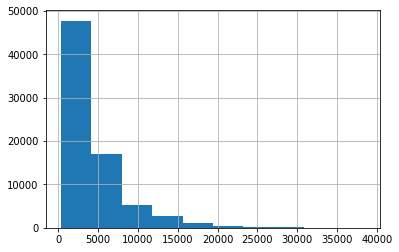

In [7]:
ticket_data.price_in_cents.hist()

Si la moyenne du prix est 4382 centimes, son max monte à 38550 et son minimum à 300. Les données des différents quartiles nous démontre le caractère illustré par l'histogramme du dessus et la présence d'outliers.

In [8]:
ticket_data.price_in_cents.describe()

count    74168.000000
mean      4382.711061
std       3739.325367
min        300.000000
25%       1900.000000
50%       3350.000000
75%       5250.000000
max      38550.000000
Name: price_in_cents, dtype: float64

## Durée min, max, moyen

La deuxième tache à effectuer était d'avoir des détails sur la durée d'un trajet. On devine assez simplement qu'en ayant la date de départ et d'arrivée qu'on pourra obtenir la durée du trajet en faisant une soustraction.

Comme les différentes colonnes de dates sont comprises comme des objets, on va d'abord les convertir en format de date pour en faire une interpréatation correcte.

In [9]:
ticket_data.arrival_ts.info()

<class 'pandas.core.series.Series'>
Int64Index: 74168 entries, 0 to 74167
Series name: arrival_ts
Non-Null Count  Dtype 
--------------  ----- 
74168 non-null  object
dtypes: object(1)
memory usage: 1.1+ MB


In [10]:
ticket_data[['arrival_ts']] = pd.to_datetime(ticket_data[['arrival_ts']].stack(),format="%Y-%m-%d %H:%M:%S+00").unstack()
ticket_data[['departure_ts']] = pd.to_datetime(ticket_data[['departure_ts']].stack(),format="%Y-%m-%d %H:%M:%S+00").unstack()

Et donc la durée d'un trajet sera le temps écoulé entre l'heure d'arrivée et l'heure de départ.

In [11]:
ticket_data['durée'] = ticket_data['arrival_ts'] - ticket_data['departure_ts']

Avec ca, on peut voir que la durée moyenne d'un trajet est de 7h 4min, la durée max est de 20 jours et celle minimum de 20 min. Les informations des quartiles nous permettent de fortement surggérer la présence d'outliers (25% et 75%)

In [12]:
ticket_data['durée'].describe()

count                        74168
mean     0 days 07:04:37.247600043
std      0 days 09:54:58.881351022
min                0 days 00:20:00
25%                0 days 03:00:00
50%                0 days 04:50:00
75%                0 days 08:00:00
max               20 days 12:51:00
Name: durée, dtype: object

## Différence du prix moyen

La troisième tache demandée était une étude du prix et de la durée en fonction du mode de transport et la distance du trajet. Comme on possède maintenant que la durée, il va falloir calculer la distance.

On va commencer simplement avec l'étude du prix en fonction du mode de transport.
Mais malheuresement le mode de transport n'est pas donné en fonction du prix, il va falloirt joindre ticket_data et providers, et on a de la chance car dans ticket_data il y a la colonne company qui peut etre reliée à celle id de provider.

Comme il peut y avoir méprise dans le csv providers, on va partir du principe que la colonne id représente l'identité du provider et company_id le groupe qui la détient. (De plus dans ticket_data les company id dépasse les 8300, ce qui n'est pas le cas de la colonne company_id de providers).

In [13]:
ticket_transport = pd.merge(ticket_data,providers,left_on='company',right_on='id')

En groupant par type de transport l'informations du prix est facilement exploitable. Selon la moyenne, le mode de transport semble clairement avoir un impact sur le prix (en centimes toujours), avec un covoiturage moins cher et le train en plus cher. En observant la colonne min il semblerait que certains trajet en train soient moins cher que le minimum en bus. Mais bon, ce qui nous intéresse ici c'est la moyenne.

In [14]:
ticket_transport.groupby('transport_type')['price_in_cents'].agg(['mean',max,min])

,mean,max,min
transport_type,,,
bus,3652.448036,22900,850
carpooling,2742.171907,16150,300
train,8506.634793,38550,490


On peut faire exactement la même chose avec la durée.
Ici la tendance change un peu, meme si le covoiturage semble avoir une durée moyenne la plus basse, c'est maintenant le bus qui occupe la première place avec une durée moyenne de 15h.

In [15]:
ticket_transport.groupby('transport_type')['durée'].agg(['mean',max,min])

,mean,max,min
transport_type,,,
bus,0 days 15:37:59.769531816,20 days 12:51:00,0 days 01:05:00
carpooling,0 days 04:06:38.330156125,1 days 05:10:00,0 days 00:20:00
train,0 days 07:20:03.435997675,2 days 00:27:00,0 days 00:39:00


On va maintenant essayer de faire le plus dur :  la distance.
Pour calculer la distance et par choix, je vais la calculer entre la ville de départ et la ville d'arrivée. Cela aurait aussi très bien pu se faire avec les stations. Le calcul de la distance va nécessiter donc de joindre 2 dataframes à chaque fois, pour avoir la latitude et longitude de la ville de départ et de celle d'arrivée. Comme on connait dans ticket_data la o_city avec un id, on va la joindre avec le dataframe cities selon la colonne id, et faire la même chose avec la colonne d_city.

In [16]:
origin_city = pd.merge(ticket_data,cities,left_on='o_city',right_on="id")
destination_city = pd.merge(ticket_data,cities,left_on='d_city',right_on="id")

origin_city c'est donc le dataframe ticket_data auquel on a joint celui de cities selon l'id dans o_city et la colonne id de cities.

In [17]:
origin_city

,id_x,company,o_station,d_station,departure_ts,arrival_ts,price_in_cents,search_ts,middle_stations,other_companies,o_city,d_city,durée,id_y,local_name,unique_name,latitude,longitude,population
0,6795025,8385,NaN,NaN,2017-10-13 14:00:00,2017-10-13 20:10:00,4550,2017-10-01 00:13:31.327+00,NaN,NaN,611,542,0 days 06:10:00,611,"Orléans, Centre-Val de Loire, France",orleans,47.907018,1.906270,114977.0
1,6795026,9,63.0,1044.0,2017-10-13 13:05:00,2017-10-14 06:55:00,1450,2017-10-01 00:13:35.773+00,"{149,418}",{13},611,542,0 days 17:50:00,611,"Orléans, Centre-Val de Loire, France",orleans,47.907018,1.906270,114977.0
2,6795027,8377,5905.0,6495.0,2017-10-13 13:27:00,2017-10-14 21:24:00,7400,2017-10-01 00:13:40.212+00,"{798,798,6794,6246}","{8377,8376}",611,542,1 days 07:57:00,611,"Orléans, Centre-Val de Loire, France",orleans,47.907018,1.906270,114977.0
3,6795028,8377,5905.0,6495.0,2017-10-13 13:27:00,2017-10-14 11:02:00,13500,2017-10-01 00:13:40.213+00,"{798,798,6794,6246}","{8377,8376}",611,542,0 days 21:35:00,611,"Orléans, Centre-Val de Loire, France",orleans,47.907018,1.906270,114977.0
4,6795029,8381,5905.0,6495.0,2017-10-13 21:46:00,2017-10-14 19:32:00,7710,2017-10-01 00:13:40.213+00,"{5983,5983}",{8380},611,542,0 days 21:46:00,611,"Orléans, Centre-Val de Loire, France",orleans,47.907018,1.906270,114977.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74163,6868361,8385,NaN,NaN,2017-10-27 08:30:00,2017-10-27 12:00:00,1850,2017-10-19 07:46:05.98+00,NaN,NaN,649,528,0 days 03:30:00,649,"Pisa, Toscana, Italia",pisa,43.722839,10.401689,NaN
74164,6868362,8385,NaN,NaN,2017-10-27 14:00:00,2017-10-27 17:40:00,2050,2017-10-19 07:46:05.98+00,NaN,NaN,649,528,0 days 03:40:00,649,"Pisa, Toscana, Italia",pisa,43.722839,10.401689,NaN
74165,6868363,8385,NaN,NaN,2017-10-27 16:50:00,2017-10-27 19:50:00,2050,2017-10-19 07:46:05.98+00,NaN,NaN,649,528,0 days 03:00:00,649,"Pisa, Toscana, Italia",pisa,43.722839,10.401689,NaN
74166,6868364,8385,NaN,NaN,2017-10-27 17:00:12,2017-10-27 20:30:12,1950,2017-10-19 07:46:05.98+00,NaN,NaN,649,528,0 days 03:30:00,649,"Pisa, Toscana, Italia",pisa,43.722839,10.401689,NaN


L'un des moyens de calculer la distance est d'utiliser les latitudes et longitudes des villes d'arrivées et de départ. Ne connaissant le calcul requis, je me suis servi de ce lien : https://stackoverflow.com/questions/19412462/getting-distance-between-two-points-based-on-latitude-longitude.

Cela donnait le calcul nécessaire pour avoir la distance, une fois cela mis sous forme de fonction, on n'a plus qu'à appliquer tout ca en fonction du dataframe origin_city contenant les latitude/longitude des villes de départ et destination_city contenant les latitudes/longitudes des villes d'arrivées.

In [18]:
def calc_distance(lat1, lat2, lon1, lon2):
    #return np.arccos(np.sin(lat1)*np.sin(lat2)+np.cos(lat1)*np.cos(lat2)*np.cos(lon2-lon1))*6371
    lat1 = np.radians(lat1)
    lat2 = np.radians(lat2)
    lon1 = np.radians(lon1)
    lon2 = np.radians(lon2)

    
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
 
    c = 2 * np.sin(np.sqrt(a))
    
    # Radius of earth in kilometers. Use 3956 for miles
    r = 6371
      
    # calculate the result
    return(c * r)

In [19]:
ticket_transport['distance'] = calc_distance(origin_city['latitude'],destination_city['latitude'],origin_city['longitude'],destination_city['longitude'])

On place toutes ces distances dans une nouvelles colonnes de ticket_data.
Bien évidemment que toutes les distances calculées sont des distances à vol d'oiseau, c'est pourquoi :

##### Piste d'améliorations
- Prendre en compte les stations plutot que les villes pour plus de précisions
- Se servir des middle_stations s'il y en a pour affiner la distance et avoir encore plus de précision.

In [20]:
ticket_transport

,id_x,company,o_station,d_station,departure_ts,arrival_ts,price_in_cents,search_ts,middle_stations,other_companies,...,company_id,provider_id,name,fullname,has_wifi,has_plug,has_adjustable_seats,has_bicycle,transport_type,distance
0,6795025,8385,NaN,NaN,2017-10-13 14:00:00,2017-10-13 20:10:00,4550,2017-10-01 00:13:31.327+00,NaN,NaN,...,11,NaN,bbc,Blablacar,False,False,False,False,carpooling,502.935701
1,6795030,8385,NaN,NaN,2017-10-06 05:30:00,2017-10-06 08:30:00,1800,2017-10-01 01:03:18.948+00,NaN,NaN,...,11,NaN,bbc,Blablacar,False,False,False,False,carpooling,502.935701
2,6795031,8385,NaN,NaN,2017-10-06 07:00:42,2017-10-06 09:30:42,2150,2017-10-01 01:03:18.948+00,NaN,NaN,...,11,NaN,bbc,Blablacar,False,False,False,False,carpooling,502.935701
3,6795032,8385,NaN,NaN,2017-10-06 07:10:00,2017-10-06 09:40:00,1700,2017-10-01 01:03:18.948+00,NaN,NaN,...,11,NaN,bbc,Blablacar,False,False,False,False,carpooling,502.935701
4,6795033,8385,NaN,NaN,2017-10-06 10:00:00,2017-10-06 12:50:00,1700,2017-10-01 01:03:18.948+00,NaN,NaN,...,11,NaN,bbc,Blablacar,False,False,False,False,carpooling,502.935701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74163,6848395,12,283.0,1595.0,2017-10-27 06:00:00,2017-10-27 17:45:00,4687,2017-10-14 19:01:07.915+00,"{561,8813}",{71},...,4,NaN,studentAgency,Student Agency,False,False,False,False,bus,1208.312305
74164,6848396,12,283.0,1593.0,2017-10-27 06:00:00,2017-10-27 17:20:00,4777,2017-10-14 19:01:07.915+00,"{561,561}",{71},...,4,NaN,studentAgency,Student Agency,False,False,False,False,bus,1208.312305
74165,6852979,12,523.0,86.0,2017-10-30 21:30:00,2017-10-31 11:45:00,1990,2017-10-16 08:10:00.399+00,"{458,458}",{13},...,4,NaN,studentAgency,Student Agency,False,False,False,False,bus,1208.312305
74166,6853589,12,283.0,523.0,2017-12-22 18:30:00,2017-12-23 04:25:00,4590,2017-10-16 10:12:35.105+00,"{330,330}",{13},...,4,NaN,studentAgency,Student Agency,False,False,False,False,bus,1208.312305


Cette donnée des distances est inexploitable en tant que telle pour la visualisation, on va préférer un regroupement par coupes selon plusieurs intervalles de distance (définis selon vos critères).
On va regrouper tous ceux entre 0 et 200km, 201 et 800km, 801 et 2000km et +2001km.

In [21]:
ticket_transport['distance_group'] = pd.cut(ticket_transport['distance'],bins=[0,200,800,2000,ticket_transport['distance'].max()],labels=['0-200km','201-800km','800-2000km','2000+km'])

Le regroupement fait, on peut maintenant voir la différence du prix en fonction du mode de transport et de la distance.
Le tableau nous permet de voir qu'il n'y a pas de trajet de plus de 2000km en bus et covoiturage (heuresement).
Seul le train semble avoir un prix progressif par rapport à la distance, alors que le covoiturage semble être dégressif et le bus presque inchangé.

In [22]:
ticket_transport.groupby(['distance_group','transport_type'])['price_in_cents'].agg(['mean',max,min])

mean      max      min
distance_group transport_type                                
0-200km        bus              3834.840000  22450.0    850.0
               carpooling       3138.823529   6150.0   1450.0
               train            8092.402235  38550.0   1210.0
201-800km      bus              3622.643659  22900.0    850.0
               carpooling       2758.532199  13100.0    300.0
               train            8520.556293  37550.0    490.0
800-2000km     bus              3933.184727  16540.0   1000.0
               carpooling       1664.102564   2150.0   1200.0
               train            9188.992874  33300.0   1070.0
2000+km        bus                      NaN      NaN      NaN
               carpooling               NaN      NaN      NaN
               train           27650.000000  27650.0  27650.0

## Les types de transports et leurs caractéristiques.

Maintenant que le minimum des taches a été fait, je vais principalement faire des graphiques. La première partie va s'axer sur les compagnies de transport.
On peut d'abord faire un groupement assez moche (mais utile) qui permet de savoir quels types de transports ont quelles caractéristiques.

Ici on voit que le covoiturage n'a ni wifi, ni siège ajustable, ni prise et ni vélo, ce qui parait normal.
Le bus ne transporte pas de vélo, et que s'il n'a pas de wifi il n'a pas de prise.

In [23]:
ticket_transport.groupby('transport_type')["has_wifi","has_plug","has_adjustable_seats","has_bicycle"].value_counts()

C:\Users\gabriel\AppData\Local\Temp/ipykernel_17916/348559991.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  ticket_transport.groupby('transport_type')["has_wifi","has_plug","has_adjustable_seats","has_bicycle"].value_counts()


transport_type  has_wifi  has_plug  has_adjustable_seats  has_bicycle
bus             True      False     False                 False           7433
                          True      True                  False           5167
                False     False     True                  False            895
                                    False                 False            287
carpooling      False     False     False                 False          41441
train           False     False     True                  False          18133
                True      True      False                 True             796
dtype: int64

Aussi on peut se demander quels sont les transport les plus utilisés dans le jeu de données.
Le covoiturage domine le bus et le train.

<AxesSubplot:xlabel='transport_type', ylabel='count'>

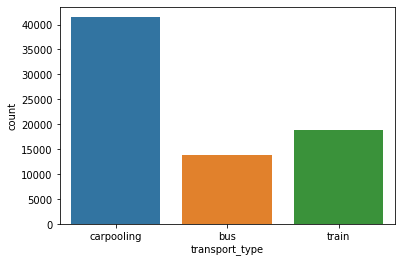

In [24]:
sns.countplot(x=ticket_transport['transport_type'])

## Distance

On peut essayer de trouver des informations sur la distance maintenant qu'elle est calculée.
Sa distribution est comme le prix : loin d'être normale et centrée.
La distance moyenne est aux environs de 400 km.

<AxesSubplot:>

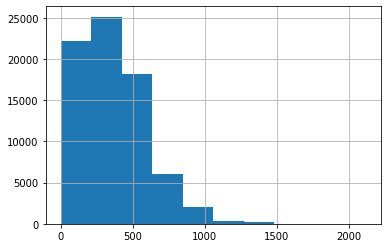

In [25]:
ticket_transport['distance'].hist()

Toujours en rapport avec les distances, on peut se demander s'il y a corrélation entre prix et distance.
Malheuresement quasiment pas, on peut voir un assez gros regroupement entre 0 et 1000km et 0 et 20000 cents nous indiquant que la distance et le prix n'ont pas forcément de lien. Une corrélation positive auraiet été l'idéal, à ce moment on aurait dû observer une pente croissante.

<AxesSubplot:xlabel='price_in_cents', ylabel='distance'>

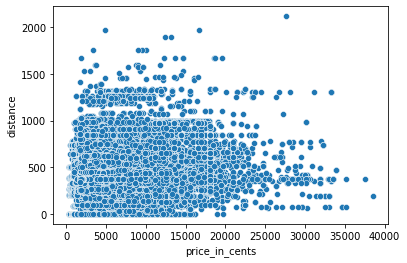

In [26]:
sns.scatterplot(x=ticket_transport['price_in_cents'],y=ticket_transport['distance'])

### Type de transport et prix

La question s'était déjà posée entre le prix et le type de transport, mais un boxplot permet de bien mieux comprendre. La présence d'outliers comme supposé est évidente dans chacune des 3 catégories. De plus cette représentation nous montre clairement la différence de prix entre le covoiturage et le train, et une moyenne de prix quasi similaire entre le covoiturage et le bus.

<AxesSubplot:xlabel='transport_type', ylabel='price_in_cents'>

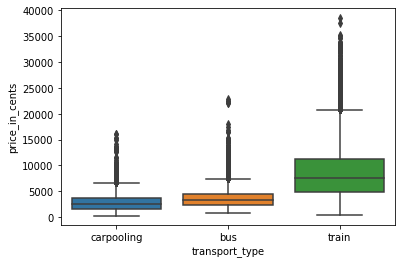

In [27]:
sns.boxplot(data=ticket_transport,x='transport_type',y='price_in_cents')

## Données temporelle et géolocalisées

On peut aussi se demander s'il y a une date de départ préférée par les utilisateurs. Et la conclusion est sans appels, le mois d'Octobre est de loin le plus actifs dans les voyages.

<AxesSubplot:>

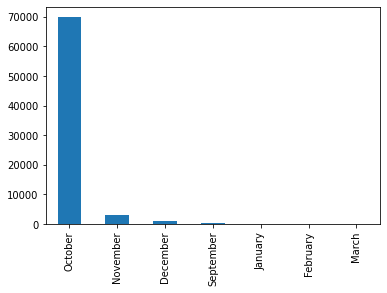

In [28]:
ticket_transport["departure_ts"].dt.month_name().value_counts().plot(kind="bar")

Savoir de quelles villes d'où viennent les départs de transports (tous confondus), et c'est Paris la grande vainqueur avec une domination sans pareille du nombre de départ, suivi de Lyon et Bordeaux.

<AxesSubplot:>

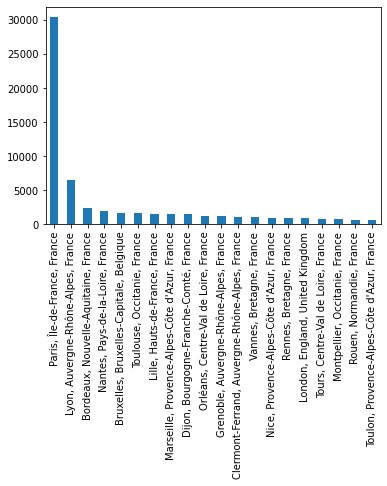

In [29]:
origin_city.local_name.value_counts()[:20].plot(kind="bar")

Et la même chose peut se faire avec la destination, une fois de plus Paris et en tête suivie de Lille et Lyon.

<AxesSubplot:>

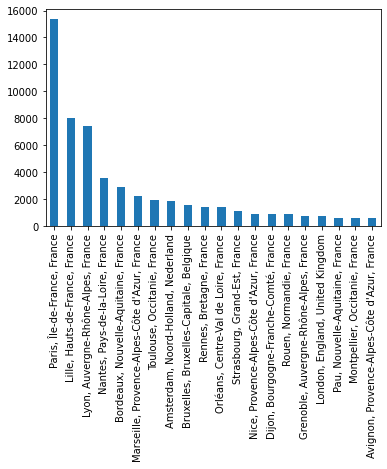

In [30]:
destination_city.local_name.value_counts()[:20].plot(kind="bar")

## Lien entre ville et prix ?

La question est légitime, il y a-t-il une relation entre ville de départ et le prix ?
Eh bien la réponse est assez décevante, car si l'id des villes se situe en abscisse on peut voir que le prix diffère peu artout sauf à un endroit.
Les villes dont l'id se situe entre 3700 et +12000 semble ne pas avoir de corrélation avec le prix, néanmoins on discerne 2 clusters :
- Les villes dont l'id est compris entre 0 et 3500
- Les villes dont l'id dest supérieur à 3500

La variance du prix est bien plus importante pour les ville de la première catégorie.

Donc non il n'y a pas de lien entre ville et prix du transport, mais cela nous a permis de voir qu'un regroupement était faisable pour séparer ces villes.

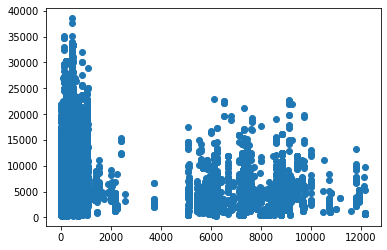

In [31]:
plt.scatter(ticket_transport[['o_city']],y=ticket_transport[['price_in_cents']])

Pour confirmer que l'observation est correcte on peut rajouter la dimension de la distance, qui nous montre que ville, prix et distance semble décorrélée à l'exception d'un clustering faisable sur 2 parties des villes comme dans le graphique du dessus.

<AxesSubplot:xlabel='o_city', ylabel='price_in_cents'>

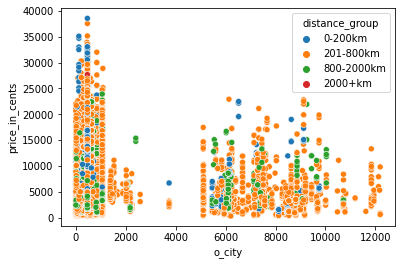

In [32]:
sns.scatterplot(data=ticket_transport,x='o_city',y='price_in_cents',hue="distance_group")

Dans la meme veine que ces 2 précédents graphes, on peut essayer de déceler un potentiel lien entre durée et prix ce qui pourrait aussi paraitre logique. Malheuresement encore une fois sur tous transports confondus il ne semble pas y avoir de liens, meme si la durée augmente la prix du transport ne semble pas augmenter.

<AxesSubplot:xlabel='durée', ylabel='price_in_cents'>

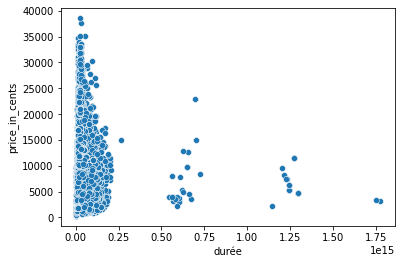

In [33]:
sns.scatterplot(data=ticket_transport,x='durée',y='price_in_cents')

Pour finir dans cette partie, on pourrait refaire la même chose avec la date de départ et le prix.
Toujours aucune réelle corrélation entre date de départ et prix.

<AxesSubplot:xlabel='departure_ts', ylabel='price_in_cents'>

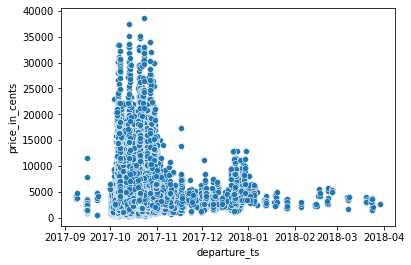

In [34]:
sns.scatterplot(data=ticket_transport,x='departure_ts',y='price_in_cents')

## Modèle prédictif du prix

Voilà pourquoi j'ai fais plus de graphique sur le prix.
C'était certes une idée proposée, mais j'avais hâte de l'essayer et l'aurais fait même si c'était pas dit.
Le prix semble être une des seules variables pour laquelle une prédiction serait cohérente, on est donc face à un problème de régression.

Et tout de suite je vais faire quelque chose : retirer des variables dont je ne me servirai pas !
- id_y, id_x des résidus lors des différents 'merge' faits
- o_city et d_city car je vais me servir de la distance entre ces 2 villes
- departure_ts, arrival_ts car ces données ne semblent pas avoir d'influence sur le prix, je ne vais donc garder que la durée.
- search_ts car selon moi ca n'a pas d'impact sur un prix (à moins que l'affluence un jour k impact le prix sur le jour k+1 ? Quelque chose à vérifier alors)
- company_id, company, provider_id pour ne garder que le nom de l'entreprise
- distance_group pour ne garder que la distance

#### Choix pouvant être changé
Je décide de ne pas garder aussi o_station et d_station.
Pourquoi ? Je ne sais pas vraiment, à ce moment il faudrait remplacer o_city et d_city par ces nouvelles variales et refaire une jointure de table pour en obtenir de plus amples informations. Etant donné qu'il manque des données pour ces 2 variables, on aurait pu faire une imputation par mode (car pas numérique) en simple, ou en fonction des d_city et o_city pour être plus correcte.

In [35]:
ticket_transport

,id_x,company,o_station,d_station,departure_ts,arrival_ts,price_in_cents,search_ts,middle_stations,other_companies,...,provider_id,name,fullname,has_wifi,has_plug,has_adjustable_seats,has_bicycle,transport_type,distance,distance_group
0,6795025,8385,NaN,NaN,2017-10-13 14:00:00,2017-10-13 20:10:00,4550,2017-10-01 00:13:31.327+00,NaN,NaN,...,NaN,bbc,Blablacar,False,False,False,False,carpooling,502.935701,201-800km
1,6795030,8385,NaN,NaN,2017-10-06 05:30:00,2017-10-06 08:30:00,1800,2017-10-01 01:03:18.948+00,NaN,NaN,...,NaN,bbc,Blablacar,False,False,False,False,carpooling,502.935701,201-800km
2,6795031,8385,NaN,NaN,2017-10-06 07:00:42,2017-10-06 09:30:42,2150,2017-10-01 01:03:18.948+00,NaN,NaN,...,NaN,bbc,Blablacar,False,False,False,False,carpooling,502.935701,201-800km
3,6795032,8385,NaN,NaN,2017-10-06 07:10:00,2017-10-06 09:40:00,1700,2017-10-01 01:03:18.948+00,NaN,NaN,...,NaN,bbc,Blablacar,False,False,False,False,carpooling,502.935701,201-800km
4,6795033,8385,NaN,NaN,2017-10-06 10:00:00,2017-10-06 12:50:00,1700,2017-10-01 01:03:18.948+00,NaN,NaN,...,NaN,bbc,Blablacar,False,False,False,False,carpooling,502.935701,201-800km
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74163,6848395,12,283.0,1595.0,2017-10-27 06:00:00,2017-10-27 17:45:00,4687,2017-10-14 19:01:07.915+00,"{561,8813}",{71},...,NaN,studentAgency,Student Agency,False,False,False,False,bus,1208.312305,800-2000km
74164,6848396,12,283.0,1593.0,2017-10-27 06:00:00,2017-10-27 17:20:00,4777,2017-10-14 19:01:07.915+00,"{561,561}",{71},...,NaN,studentAgency,Student Agency,False,False,False,False,bus,1208.312305,800-2000km
74165,6852979,12,523.0,86.0,2017-10-30 21:30:00,2017-10-31 11:45:00,1990,2017-10-16 08:10:00.399+00,"{458,458}",{13},...,NaN,studentAgency,Student Agency,False,False,False,False,bus,1208.312305,800-2000km
74166,6853589,12,283.0,523.0,2017-12-22 18:30:00,2017-12-23 04:25:00,4590,2017-10-16 10:12:35.105+00,"{330,330}",{13},...,NaN,studentAgency,Student Agency,False,False,False,False,bus,1208.312305,800-2000km


In [36]:
to_drop = ["arrival_ts",'departure_ts','id_y','company_id','id_x','company','o_station','d_station','search_ts','provider_id','fullname','distance_group','o_city','d_city']

Je vais faire une copie du dataframe ayant 'tout' dans un nouveau.

In [37]:
ticket_transport2= ticket_transport.copy()
ticket_transport2.drop(columns=to_drop,inplace=True)

Avant meme de parler de modèle et d'imputation avec des lignes de codes, on va voir s'il manque des données dans le tableau.

Mince il en manque...middle_stations et other_companies comme déjà dit ne m'inquiètent pas pour le peu qu'on interprète le manque de données par un trajet direct, par contre il en manque dans les caractéristiques des transports et ça c'est pas cool.

In [38]:
ticket_transport2.isnull().sum()

price_in_cents              0
middle_stations         41441
other_companies         41441
durée                       0
name                        0
has_wifi                   16
has_plug                   16
has_adjustable_seats       16
has_bicycle                16
transport_type              0
distance                    0
dtype: int64

On va d'abord gérer le carsde middle_stations qu'on va simplifier par :
- S'il y a de la donnée, c'est que le trajet n'est pas direct = 1
- S'il n'y a pas de données, c'est que le trajet est direct = 0

#### Piste d'amélioration
Au lieu de mettre du 0 et 1, remplacer par le nombre de stations. Ainsi si un trajet passait par 4 stations, alors on aurait 4 et pas 1. Ca serait surement plus correct de faire ca.

In [39]:
ticket_transport2['middle_stations'].fillna(0,inplace=True)
ticket_transport2['middle_stations'] = ticket_transport2['middle_stations'].apply(lambda x: 1 if x !=0 else x)

On fait la meme chose que ci-dessus avec other_companies

In [40]:
ticket_transport2['other_companies'].fillna(0,inplace=True)
ticket_transport2['other_companies'] = ticket_transport2['other_companies'].apply(lambda x: 1 if x !=0 else x)

Maintenant on va essayer d'imputer les cacractéristiques des transports. Si on se rappel un groupement que j'avais fait, on avait pu discerner des implications dans les caractéristiques.
Je vais réafficher ce groupement.

On se souvient par exemple que si un bus n'a pas de wifi il n'a pas de prises...Eh bien on va imputer comme ca

In [41]:
ticket_transport.groupby('transport_type')["has_wifi","has_plug","has_adjustable_seats","has_bicycle"].value_counts()

C:\Users\gabriel\AppData\Local\Temp/ipykernel_17916/348559991.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  ticket_transport.groupby('transport_type')["has_wifi","has_plug","has_adjustable_seats","has_bicycle"].value_counts()


transport_type  has_wifi  has_plug  has_adjustable_seats  has_bicycle
bus             True      False     False                 False           7433
                          True      True                  False           5167
                False     False     True                  False            895
                                    False                 False            287
carpooling      False     False     False                 False          41441
train           False     False     True                  False          18133
                True      True      False                 True             796
dtype: int64

Si le transport est du covoiturage alors il n'y a pas de wifi, de prises, de sièges ajustables et de vélos.

In [42]:
ticket_transport2.loc[ticket_transport2['transport_type']=="carpooling",["has_wifi","has_plug","has_adjustable_seats","has_bicycle"]] = ticket_transport2.loc[ticket_transport2['transport_type']=="carpooling",["has_wifi","has_plug","has_adjustable_seats","has_bicycle"]].fillna(False)

Si le transport est du bus alors il n'y a pas de vélos.

In [43]:
ticket_transport2.loc[ticket_transport2['transport_type']=="bus","has_bicycle"] = ticket_transport2.loc[ticket_transport2['transport_type']=="bus","has_bicycle"].fillna(False)

Si le transport est du bus et qu'il n'a pas de wifi alors il n'a pas de prise.

In [44]:
ticket_transport2.loc[(ticket_transport2['transport_type']=="bus")&(ticket_transport2['has_wifi']==False),"has_plug"] = ticket_transport2.loc[(ticket_transport2['transport_type']=="bus")&(ticket_transport2['has_wifi']==False),"has_plug"].fillna(False)

Si le transport est un train et qu'il n'a pas de wifi alors il n'a pas de prise.
Si le transport est un train et qu'il n'a pas de prise alors il n'a pas de wifi

In [45]:
ticket_transport2.loc[(ticket_transport2['transport_type']=="train")&(ticket_transport2['has_wifi']==False),"has_plug"] = ticket_transport2.loc[(ticket_transport2['transport_type']=="train")&(ticket_transport2['has_wifi']==False),"has_plug"].fillna(False)
ticket_transport2.loc[(ticket_transport2['transport_type']=="train")&(ticket_transport2['has_plug']==False),"has_wifi"] = ticket_transport2.loc[(ticket_transport2['transport_type']=="train")&(ticket_transport2['has_plug']==False),"has_wifi"].fillna(False)

Bien sûr, toutes ces imputations se fondent sur de fortes suppositions que l'on déduit du groupement.
On pourrait continuer avec ces groupements, mais ayant déjà observé où manquait les valeurs, on décide de remplacer par le mode.

In [46]:
for col in ["has_wifi","has_plug","has_adjustable_seats","has_bicycle"]:
    ticket_transport2[col] =  ticket_transport2[col].fillna(ticket_transport2[col].mode().iloc[0])

Parfait !
On n'a plus de valeurs manquantes.

In [47]:
ticket_transport2.isnull().sum()

price_in_cents          0
middle_stations         0
other_companies         0
durée                   0
name                    0
has_wifi                0
has_plug                0
has_adjustable_seats    0
has_bicycle             0
transport_type          0
distance                0
dtype: int64

### Encoder les variables

En tant que telles on ne peut toujours pas construire de modèle à cause de : des variables catégorielles.

On a encore des objets, des bool, des timedeltas...Il y a encore du boulot

In [48]:
ticket_transport2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74168 entries, 0 to 74167
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype          
---  ------                --------------  -----          
 0   price_in_cents        74168 non-null  int64          
 1   middle_stations       74168 non-null  int64          
 2   other_companies       74168 non-null  int64          
 3   durée                 74168 non-null  timedelta64[ns]
 4   name                  74168 non-null  object         
 5   has_wifi              74168 non-null  bool           
 6   has_plug              74168 non-null  bool           
 7   has_adjustable_seats  74168 non-null  bool           
 8   has_bicycle           74168 non-null  bool           
 9   transport_type        74168 non-null  object         
 10  distance              74168 non-null  float64        
dtypes: bool(4), float64(1), int64(3), object(2), timedelta64[ns](1)
memory usage: 4.8+ MB


L'un des changements que l'on peut faire c'est de transformer toutes les variables booléenne en 0 et 1.

In [49]:
new_col2=["has_wifi","has_plug","has_adjustable_seats","has_bicycle"]
ticket_transport2[new_col2] = ticket_transport2[new_col2].astype(int)


Pour l'instant on a gardé les distances, on va donc les scaler pour les rendre plus facile à "ingérer" et utiliser un robust scaler pour mieux gérer les outliers.

In [50]:
rs = RobustScaler()
col = ['distance']

ticket_transport2[col] = rs.fit_transform(ticket_transport2[col])

On va aussi faire un peu de feature engineering avec la durée, car son format de timedelta la rend inexplotable. Je vais donc décomposer en plus petits éléments exploitables.
On récupère le nombre de jours, d'heures et de minutes, puis on se débarrase de la colonnes originale.

In [51]:
ticket_transport2['duree_d'] = ticket_transport2['durée'].dt.components.iloc[:,0]
ticket_transport2['duree_h'] = ticket_transport2['durée'].dt.components.iloc[:,1]
ticket_transport2['duree_m'] = ticket_transport2['durée'].dt.components.iloc[:,2]

ticket_transport2.drop(columns=['durée'],inplace=True)

Maintenant qu'on a encodé toutes les variables nécessaires on va dummifier tout le reste des variables qu'on n'a pas encore touché.
Le résultat est...comme imaginé, tout va bien pour le moment !

In [52]:
data = pd.get_dummies(ticket_transport2)
data

,price_in_cents,middle_stations,other_companies,has_wifi,has_plug,has_adjustable_seats,has_bicycle,distance,duree_d,duree_h,...,name_navettedeVatry,name_ouibus,name_studentAgency,name_tgv,name_thalys,name_train,name_vatry,transport_type_bus,transport_type_carpooling,transport_type_train
0,4550,0,0,0,0,0,0,0.384259,0,6,...,0,0,0,0,0,0,0,0,1,0
1,1800,0,0,0,0,0,0,0.384259,0,3,...,0,0,0,0,0,0,0,0,1,0
2,2150,0,0,0,0,0,0,0.384259,0,2,...,0,0,0,0,0,0,0,0,1,0
3,1700,0,0,0,0,0,0,0.384259,0,2,...,0,0,0,0,0,0,0,0,1,0
4,1700,0,0,0,0,0,0,0.384259,0,2,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74163,4687,1,1,0,0,0,0,2.795073,0,11,...,0,0,1,0,0,0,0,1,0,0
74164,4777,1,1,0,0,0,0,2.795073,0,11,...,0,0,1,0,0,0,0,1,0,0
74165,1990,1,1,0,0,0,0,2.795073,0,14,...,0,0,1,0,0,0,0,1,0,0
74166,4590,1,1,0,0,0,0,2.795073,0,9,...,0,0,1,0,0,0,0,1,0,0


Et on peut séparer la variables à prédire du reste

In [53]:
y = data.price_in_cents
X = data.loc[:,data.columns != 'price_in_cents']


On effectue les rudiments du machine learning, on va spliter les données en bases d'entrainement et de test.

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=12102001)

Tout est bon !
On peut enfin s'occuper de créer les modèles et effectuer des prédictions, l'étape la plus cool mais aussi la plus frustrante.
Si tout allait bien avant, on va voir si tout va toujours bien après.

### Régression linéaire

Fallait faire un choix, je commende donc par la régression linéaire pour savoir comment performe le modèle sur les données.

In [55]:
lr = LinearRegression()
lr.fit(X_train,y_train)

LinearRegression()

Ah, le modèle semble ne pas performer correctement sur les données. Légèrement plus qu'une décision aléatoire, c'est pas très bon tout ça...

In [56]:
lr.score(X_test,y_test)

0.5751227634934271

### XGBRegressor

Au vu de la piètre performance de la régression linéaire on va essayer avec le XGBRegressor

In [57]:
xgb = XGBRegressor()
xgb.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

C'est un peu mieux que le précédent, mais je pense qu'on peut toujours faire mieux.

In [58]:
xgb.score(X_test,y_test)

0.7543827961571818

### RandomForest

Je décide d'essayer un dernier modèle pour voir s'il y a moyen d'améliorer les choses. On va essayer un randomforest

In [59]:
rfr = RandomForestRegressor()
rfr.fit(X_train,y_train)

RandomForestRegressor()

Le score est légèrement mieux, on pourrait presque s'en contenter, mais des améliorations peuvent être apportées.

In [60]:
rfr.score(X_test,y_test)

0.7935186768292064

# Conclusion

Voilà donc le travail que je pouvais fournir compte tenu de ce que je suis capable de faire et de la contrainte de temps que j'avais. A travers ces différents graphs j'ai pu voir les différents type de transports empruntés et ceux qui l'étaient plus ou moins, de la même manière que les différentes corrélations que j'aurais pu croire comme existantes alors que pas du tout. Mais le travail ici est loin d'etre parfait et exhaustif, c'est pourquoi je vais lister ici ce qui j'aurais pu faire si j'avais été un peu plus libre :

## Pistes d'améliorations :
- Un dashboard intéractif avec Dash ou shiny (en R), pour par exemple choisir des graphes en fonction d'une séléction des compagnies ou du type de transports
- Faire des graphes chronologiques en tenant compte de la date du départ et pouvoir tirer des conclusions plus poussées qu'un simple prix à partir de la date
- Une utilisation des stations et pas des villes pour calculer les distances pour avoir plus de précisions et en tenir compte dans les graphiques. Ajouter les stations intermédiaires pour avoir une distance toujours plus parfaites.
- Intégrer la dimension de la population pour voir le prix en fonction de la ville et de sa taille (j'imagine bien un graphique des villes en fonctions des prix avec des cercles dont la taille varierait avec la population). Comme il y avait des données manquantes on aurait pu les compléter par scraping ou API externe pour la population.

Le modèle prédictif était ma partie favorite (ca m'a fait pensé à Kaggle), mais une qui pouvait aussi être le plus améliorée :
- Les variables utilisées pour la prédiction sont celles que j'ai choisies et ne constituent surement pas le meilleur choix, on aurait pu utiliser un PCA/NMF ou une séléction à travers le CatBoosting pour déterminer quelles variables sont les plus utiles.
- Faire de la cross-validation pour produire un véritable score pour chacun des modèles sur la généralisation
- Evidemment fine-tuner les modèles avec une GridSearch/RandomizedSearch pour aller gratter quelques pourcentages de précision
- Pourquoi pas créer le fameux regroupement de villes comme mentionnées pour ajouter une feature pour les villes ayant un grande variances de prix. La meme chose pourrait etre faite avec la durée.
- Intégrer les idées du paragraphe ci-dessus pourrait nettement améliorer les performances des modèles.
- Tout ca permettra de rendre ces résultats plus consistant, car là si on ré-exécuter les cellules plusieurs fois on peut tomber sur des scores absolument horribles.

Sinon voila tout, je crois que j'ai dit et fais tout ce que je pouvais.
Exercice très appréciable.
Comme je sais que ce que j'ai fais n'est pas parfait, si jamais vous avez des retours ca serait avec grand plaisir !